# Topology Reconstruction
### Algorithm to reconstruct $T_1$, the initial kinetic energy of the most energetic primary electron, and $\cos\theta$, the opening angle between the initial directions of the two primary electrons, for each event in the nexus data sample. The reconstruction uses nexus hits, knowledge of the vertex hit, and a graph theory algorithm to assign hits to one or the other primary electron. In addition to the reconstructed quantities $T_{1,reco}$ and $\cos\theta_{reco}$, for comparison purposes we store in our output file also the generator-level quantities  $T_{1,gen}$ and $\cos\theta_{gen}$, as well as quantities that use nexus hits but MC truth information instead of graph theory to classify hits as produced by one or the other electron.

## Imports

In [1]:
import numpy as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse.csgraph import depth_first_order
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx


## Configuration

In [2]:
# Input file
pressure = 5
model = "mbb"
file   = f"../h5files/4mm/generation_nudobe_{model}_short_{pressure}bar.h5"
file = "/Users/mistryk2/Packages/nexus/mbb.h5"


# Event, when testing on single events
#evt_id = 0

# Number of events to process
nevts = 10000

# Maximum hit distance from vertex for electron direction calculation
R = 12 #mm 

# Reconstruction method: either 'endtrack' seed, or 'vertex' seed
reco_seed_method = 'vertex_seed'
#reco_seed_method = 'endtrack_seed'


## Functions

In [3]:
# Simple function to ensure T1 > T2
def reorder_electrons_fun(T1,T2):
    if T1 > T2:
        return T1, T2
    else:
        return T2, T1

In [4]:
# cos(theta) = (p1x*p2x + p1y*p2y + p1z*p2z) / (p1*p2)
def costheta_fun(p1x,p1y,p1z,p2x,p2y,p2z):
    p1 = np.sqrt(p1x**2 + p1y**2 + p1z**2)
    p2 = np.sqrt(p2x**2 + p2y**2 + p2z**2)
    costheta = (p1x*p2x + p1y*p2y + p1z*p2z) / (p1*p2)
    return costheta
    

In [5]:
# Find primary ancestor id of a particle in the particle df
def ancestor_id_fun(particle_id_in):
    pid = particle_id_in
    if (pid == 0):
        return pid
    is_primary = 0
    while is_primary == 0:
        is_primary = df_particles[df_particles.particle_id == pid].primary.item()
        if (is_primary):
            return pid
        else:
            mid = df_particles[df_particles.particle_id == pid].mother_id.item()
            pid = mid

In [6]:
# Function returning the first principal component of 3D hits, 
# i.e. the direction vector of the 'best fit' line in the least squares sense.
# Used both for true and reco hit collections
def line_fit_fun(df_sel_hits):
    x_array = df_sel_hits.x.to_numpy()
    x_array = np.append(x_array,0.) # vertex
    y_array = df_sel_hits.y.to_numpy()
    y_array = np.append(y_array,0.) # vertex
    z_array = df_sel_hits.z.to_numpy()
    z_array = np.append(z_array,0.) # vertex
    
    data_comb = np.concatenate((x_array[:, np.newaxis], 
                                y_array[:, np.newaxis], 
                                z_array[:, np.newaxis]), axis=1)
    datamean = data_comb.mean(axis=0)
    uu, dd, vv = np.linalg.svd(data_comb - datamean)
    vx = vv[0][0]
    vy = vv[0][1]
    vz = vv[0][2]
    return vx,vy,vz

In [7]:
def euclidean_distance_fun(coord1, coord2):
    return np.linalg.norm(np.array(coord1) - np.array(coord2))


In [8]:
# Return global_hit_ids of nodes in reconstructed e1 and e2, ordered starting from the vertex
def divide_nodes_into_groups_fun(graph):
    start_coords = np.zeros(3)
    distances = {}
    
    for node in graph.nodes():
        distances[node] = euclidean_distance_fun(start_coords, graph.nodes[node]['coords'])
    
    # Sort nodes based on their distances from the vertex
    sorted_node_ids = sorted(distances.keys(), key=lambda node: distances[node])

    # Initialize groups
    track_1 = [sorted_node_ids[0]]  # First node with the shortest distance
    track_2 = [sorted_node_ids[1]]  # Second node with the second shortest distance

    # Assign nodes to groups iteratively
    for node_id in sorted_node_ids[2:]:
        distance_to_last_node_group1 = euclidean_distance_fun(graph.nodes[track_1[-1]]['coords'], graph.nodes[node_id]['coords'])
        distance_to_last_node_group2 = euclidean_distance_fun(graph.nodes[track_2[-1]]['coords'], graph.nodes[node_id]['coords'])

        if distance_to_last_node_group1 <= distance_to_last_node_group2:
            track_1.append(node_id)
        else:
            track_2.append(node_id)

    return track_1, track_2

In [9]:
def add_global_hit_id_column_fun():
    global df_hits
    nhits = len(df_hits)
    # Add  a global_hit_id column to hits dataframe, so that hit IDs are unique within one event
    #df_hits['global_hit_id'] = np.arange(nhits) # this yields a warning, so change with next line
    df_hits = df_hits.assign(global_hit_id = np.arange(nhits))
    return df_hits
    

In [10]:
def add_distance_column_fun():
    global df_hits
    # Add hit distance to vertex, to the hits dataframe. Note that this assumes that vertex is  (0,0,0) for all events
    df_hits['distance'] = np.sqrt(df_hits.x**2 + df_hits.y**2 + df_hits.z**2)
    return df_hits

In [11]:
def gen_quantities_fun():
    global df_particles
    # T_1,gen
    T1_gen = df_particles[df_particles.particle_id == 1].kin_energy.item()
    T2_gen = df_particles[df_particles.particle_id == 2].kin_energy.item()
    T1_gen, T2_gen = reorder_electrons_fun(T1_gen,T2_gen)
    #print(T1_gen,T2_gen,T1_gen+T2_gen)
    
    # cos(theta_gen)
    p1x = df_particles[df_particles.particle_id == 1].initial_momentum_x.item()
    p1y = df_particles[df_particles.particle_id == 1].initial_momentum_y.item()
    p1z = df_particles[df_particles.particle_id == 1].initial_momentum_z.item()
    
    p2x = df_particles[df_particles.particle_id == 2].initial_momentum_x.item()
    p2y = df_particles[df_particles.particle_id == 2].initial_momentum_y.item()
    p2z = df_particles[df_particles.particle_id == 2].initial_momentum_z.item()
    
    costheta_gen = costheta_fun(p1x,p1y,p1z,p2x,p2y,p2z)
    #print(costheta_gen)
    
    return T1_gen, costheta_gen
    

In [12]:
def add_ancestor_id_column_fun():
    global df_hits
    nhits = len(df_hits)
    # Add a ancestor_id column to the hits df, with values 1 or 2, to identify which primary electron produced the hit
    
    keys = df_hits.global_hit_id.to_numpy()
    values = np.zeros(nhits, dtype='i')
    pid_array = df_hits.particle_id.to_numpy()
    
    for i in np.arange(nhits):
        values[i] = ancestor_id_fun(pid_array[i])
        
    df_ancestor_id = pd.DataFrame({'global_hit_id': keys, 'ancestor_id': values})
    df_hits = pd.merge(df_hits, df_ancestor_id, on='global_hit_id')
    
    return df_hits

In [13]:
def true_quantities_fun():
    global df_hits
    # T1_true. Should be the same as T1_gen
    # We separate hits based on ancestor_id
    e1true_hit_mask = df_hits.ancestor_id == 1
    df_e1true_hits = df_hits[e1true_hit_mask]
    T1_true = df_e1true_hits.energy.sum()
    
    e2true_hit_mask = df_hits.ancestor_id == 2
    df_e2true_hits = df_hits[e2true_hit_mask]
    T2_true = df_e2true_hits.energy.sum()
    
    T1_true, T2_true = reorder_electrons_fun(T1_true,T2_true)
    #print(T1_true,T2_true,T1_true+T2_true)
    
    # costheta_true
    # Normally, for each electron we keep all hits whose distance from vertex is <= R. 
    # For electrons where no hits satisfy this condition, we only take the clostest hit to the vertex, even if its distance is greater than R
    distance1_mask = df_e1true_hits.distance <= R
    nhits1true = distance1_mask.sum()
    if (nhits1true >= 1):
        df_e1true_sel_hits = df_e1true_hits[distance1_mask]
    else:
        hitrow = df_e1true_hits['distance'].idxmin()
        df_e1true_sel_hits = df_e1true_hits.iloc[hitrow]
        
    distance2_mask = df_e2true_hits.distance <= R
    nhits2true = distance2_mask.sum()
    if (nhits2true >= 1):
        df_e2true_sel_hits = df_e2true_hits[distance2_mask]
    else:
        hitrow = df_e2true_hits['distance'].idxmin()
        df_e2true_sel_hits = df_e2true_hits.iloc[hitrow]

    #print(nhits1true,nhits2true)
    v1x, v1y, v1z = line_fit_fun(df_e1true_sel_hits)
    v2x, v2y, v2z = line_fit_fun(df_e2true_sel_hits)
    costheta_true = costheta_fun(v1x,v1y,v1z,v2x,v2y,v2z)
    #print(costheta_true)
    
    return T1_true, costheta_true
    

In [14]:
def add_reco_hit_id_column_vertex_seed_fun():
    global df_hits
    
    # First, create the graph
    # Extract from the dataframe the 3D coordinates of each hit. Hits will become the graph nodes
    graph = nx.Graph()

    # Add vertex at origin not needed. Comment out
    #graph.add_node("vertex", coords=(0., 0., 0.))

    for index, row in df_hits.iterrows():
        graph.add_node(row['global_hit_id'], coords=(row['x'],row['y'],row['z']))
    #graph.nodes(data=True)
    
    # Second, divide nodes into e1 and e2 groups
    #start_node = "vertex"
    e1reco_global_hit_ids, e2reco_global_hit_ids = divide_nodes_into_groups_fun(graph)
    #print("Track 1:", e1reco_global_hit_ids)
    #print("Track 2:", e2reco_global_hit_ids)
    #print("len(e1reco_global_hit_ids) = ", len(e1reco_global_hit_ids), "\nlen(e2reco_global_hit_ids) = ", len(e2reco_global_hit_ids), "\nlen(e1reco_global_hit_ids) + len(e2reco_global_hit_ids) =", len(e1reco_global_hit_ids)+len(e2reco_global_hit_ids))
    
    # Third, add reco_hit_id column according to ordering in e1reco_global_hit_ids and e2reco_global_hit_ids lists. Reorder rows by 'reco_hit_id'
    keys = e1reco_global_hit_ids
    values = np.zeros(nhits, dtype='i')

    my_dict1 = {}
    reco_hit_id = 1
    for key in e1reco_global_hit_ids:
        my_dict1[key] = reco_hit_id
        reco_hit_id += 1
    df_reco_particle_id1 = pd.DataFrame({'global_hit_id': list(my_dict1.keys()), 'reco_hit_id': list(my_dict1.values())})

    my_dict2 = {}
    reco_hit_id = -1
    for key in e2reco_global_hit_ids:
        my_dict2[key] = reco_hit_id
        reco_hit_id -= 1
    df_reco_particle_id2 = pd.DataFrame({'global_hit_id': list(my_dict2.keys()), 'reco_hit_id': list(my_dict2.values())})

    df_reco_particle_id = df_reco_particle_id1.append(df_reco_particle_id2, ignore_index=True)
    #df_reco_particle_id
    
    # Fourth, merge df with 'reco_hit_id' into hits df. Reorder rows by 'reco_hit_id'
    df_hits = pd.merge(df_hits, df_reco_particle_id, on='global_hit_id')
    df_hits = df_hits.sort_values(by = 'reco_hit_id') 
    
    return df_hits

    

In [15]:
def add_reco_hit_id_column_endtrack_seed_fun():
    global df_hits
    
    # First, we compute the distances between all hits. For this method, we have to add the vertex hit, at (0,0,0)
    x_array = df_hits['x'].to_numpy()
    y_array = df_hits['y'].to_numpy()
    z_array = df_hits['z'].to_numpy()
    
    x_array = np.append(x_array,0.)
    y_array = np.append(y_array,0.)
    z_array = np.append(z_array,0.)
    nhits = len(x_array)

    matrix = np.zeros([nhits,nhits])
    for j in np.arange(nhits-1):
        for k in np.arange(j+1,nhits):
            dx = x_array[j] - x_array[k]
            dy = y_array[j] - y_array[k]
            dz = z_array[j] - z_array[k]
            distance = np.sqrt(dx**2 + dy**2 + dz**2)
            matrix[j][k] = distance
            matrix[k][j] = distance
            
    # Second, apply the travelling salesman problem (TSP) algorithm starting from the most energetic hit
    # in the event, taken to be the extreme of a track. We connect the hits using the shortest distance
    emax_id  = df_hits['energy'].idxmax()
    
    checked_hit_ids = []
    visit_id = emax_id
    while len(checked_hit_ids) != nhits:
        #print(len(checked_hits))
        cond = True
        while cond:
            # This is the furthest hit from the hit being visited
            furthest_hit_id = np.argmax(matrix[visit_id])
            matrix[visit_id][visit_id]=1.e6 # This is just to ensure that closest_hit_id in next line can be computed using argmin
            closest_hit_id = np.argmin(matrix[visit_id]) #next hit to visit is the clostest to the one being visited
            if closest_hit_id in checked_hit_ids:
                cond = True
                matrix[visit_id][closest_hit_id]=matrix[visit_id][furthest_hit_id]+1 # This is to ensure that this hit is not visited again
            else:
                cond = False
                visited_id = visit_id
                checked_hit_ids.append(visited_id)
                visit_id = closest_hit_id
                
    # Third, we find the vertex hit position within the checked_hits array. The vertex hit has ID equal to nhits-1
    # Then, all hits from the vertex hit (vertex_hit_index) to the most energetic hit are assigned positive and sequential
    # reco_hit_id values, signaling e1, following the ordering in checked_hit_ids. 
    # All other hits are assigned negative and sequential reco_hit_id values 
    # Use a dictionary with keys equal to checked_hit_ids, values equal to reco_hit_ids, for that
    vertex_hit_index = checked_hit_ids.index(nhits-1)
    keys = checked_hit_ids
    values = np.zeros(nhits, dtype='i')

    reco_hit_id = 1
    for i in np.arange(vertex_hit_index-1,-1,-1):
        values[i] = reco_hit_id
        reco_hit_id += 1

    reco_hit_id = -1
    for i in np.arange(vertex_hit_index+1,nhits):
        values[i] = reco_hit_id
        reco_hit_id -= 1

    df_reco_particle_id = pd.DataFrame({'global_hit_id': keys, 'reco_hit_id': values})
    
    # Fourth, merge df with 'reco_hit_id' into hits df. Reorder rows by 'reco_hit_id'. 
    # Note that df_hits has no vertex hit, df_reco_particle_id has it. When merging, the vertex hit is ignored, as we want
    df_hits = pd.merge(df_hits, df_reco_particle_id, on='global_hit_id')
    df_hits = df_hits.sort_values(by = 'reco_hit_id') 
    
    return df_hits
    

In [16]:
def reco_quantities_fun():
    global df_hits
    T1_reco = -999
    costheta_reco = -999
    
    # T1_reco
    # First, we separate hits based on reco_hit_id sign
    e1reco_hit_mask = df_hits.reco_hit_id > 0
    df_e1reco_hits = df_hits[e1reco_hit_mask]
    df_e1reco_hits = df_e1reco_hits.sort_values(by = 'reco_hit_id', ascending = True)
    if (len(df_e1reco_hits) == 0):
        print('No e1reco hits, cannot reconstruct!')
        return T1_reco, costheta_reco

    e2reco_hit_mask = df_hits.reco_hit_id < 0
    df_e2reco_hits = df_hits[e2reco_hit_mask]
    df_e2reco_hits = df_e2reco_hits.sort_values(by = 'reco_hit_id', ascending = False)
    if (len(df_e2reco_hits) == 0):
        print('No e2reco hits, cannot reconstruct!')
        return T1_reco, costheta_reco

    
    # Second, we compute T1_reco and T2_reco
    T1_reco = df_e1reco_hits.energy.sum()
    T2_reco = df_e2reco_hits.energy.sum()
    T1_reco, T2_reco = reorder_electrons_fun(T1_reco,T2_reco)
    #print(T1_reco,T2_reco,T1_reco+T2_reco)
    
    # cotheta_reco
    # Start by dealing with hits near the vertex, until one hit has a distance exceeding the maximum radius.
    # If all hits meet the condition (n_outer_hits = 0), then include them all

    # First, e1. Find first row that does not meet distance requirement. Then subtract one for last reco_hit_id to be included
    n_outer_hits = len(df_e1reco_hits[df_e1reco_hits.distance > R])
    if (n_outer_hits > 0):
        reco_hit_id_max = df_e1reco_hits[df_e1reco_hits.distance > R].reco_hit_id.iloc[0] - 1
    else:
        reco_hit_id_max = df_e1reco_hits.reco_hit_id.max()

    df_e1reco_sel_hits = df_e1reco_hits[df_e1reco_hits.reco_hit_id <= reco_hit_id_max]
    #df_e1recosel_hits

    # Second e2. Find first row that does not meet distance requirement. Then add one for last reco_hit_id to be included
    n_outer_hits = len(df_e2reco_hits[df_e2reco_hits.distance > R])
    if (n_outer_hits > 0):
        reco_hit_id_min = df_e2reco_hits[df_e2reco_hits.distance > R].reco_hit_id.iloc[0] + 1
    else:
        reco_hit_id_min = df_e2reco_hits.reco_hit_id.min()

    df_e2reco_sel_hits = df_e2reco_hits[df_e2reco_hits.reco_hit_id >= reco_hit_id_min]
    #df_e2recosel_hits
    
    # Third, do the two line fits and compute the opening angle among them
    v1x, v1y, v1z = line_fit_fun(df_e1reco_sel_hits)
    v2x, v2y, v2z = line_fit_fun(df_e2reco_sel_hits)
    costheta_reco = costheta_fun(v1x,v1y,v1z,v2x,v2y,v2z)
    #print(costheta_reco)
    
    return T1_reco, costheta_reco

## Input nexus files

In [17]:
# Particles dataframe.
# df_particles_allevts = pd.DataFrame.from_records(tb.open_file(file).root.MC.particles.read())
df_particles_allevts = pd.read_hdf(file, "MC/particles")
# Hits dataframe.
# df_hits_allevts = pd.DataFrame.from_records(tb.open_file(file).root.MC.hits.read())
df_hits_allevts = pd.read_hdf(file, "MC/hits")

## Event loop

In [18]:

event_id_arr = np.zeros(nevts)
T1_gen_arr = np.zeros(nevts)
costheta_gen_arr = np.zeros(nevts)
T1_true_arr = np.zeros(nevts)
costheta_true_arr = np.zeros(nevts)
T1_reco_arr = np.zeros(nevts)
costheta_reco_arr = np.zeros(nevts)

hits = []


# Header
print('event_id, T1_gen, costheta_gen, T1_true, costheta_true, T1_reco, costheta_reco')

# Event loop should go here
for evt_id in np.arange(nevts):

    # Only particles and hits from event_id = evt_id, to deal one event at the time
    df_particles = df_particles_allevts[df_particles_allevts.event_id == evt_id]
    df_hits = df_hits_allevts[df_hits_allevts.event_id == evt_id]

    nhits = len(df_hits)
    df_hits = add_global_hit_id_column_fun()
    df_hits = add_distance_column_fun()

    # Step 1: Generator-level $T_1$ and $\cos\theta$
    T1_gen, costheta_gen = gen_quantities_fun()

    # Step 2: Truth-level $T_1$ and $\cos\theta$
    df_hits = add_ancestor_id_column_fun()
    T1_true, costheta_true = true_quantities_fun()

    # Step 3: Reco-level $T_1$ and $\cos\theta$
    if (reco_seed_method == 'vertex_seed'):
        df_hits = add_reco_hit_id_column_vertex_seed_fun()
    elif (reco_seed_method == 'endtrack_seed'):
        df_hits = add_reco_hit_id_column_endtrack_seed_fun()
    else:
        raise SystemExit('Unrecognized reco seed method, stop executing!')
    T1_reco, costheta_reco = reco_quantities_fun()

    # if (evt_id % 100) == 0:
    print(evt_id,',',T1_gen,',',costheta_gen,',',T1_true,',',costheta_true,',',T1_reco,',',costheta_reco)

    # hits.append(df_hits)

    event_id_arr[evt_id] = evt_id
    T1_gen_arr[evt_id] = T1_gen
    costheta_gen_arr[evt_id] = costheta_gen
    T1_true_arr[evt_id] = T1_true
    costheta_true_arr[evt_id] = costheta_true
    T1_reco_arr[evt_id] = T1_reco
    costheta_reco_arr[evt_id] = costheta_reco
    


event_id, T1_gen, costheta_gen, T1_true, costheta_true, T1_reco, costheta_reco
0 , 1.446865200996399 , -0.2693907543800328 , 1.4468652 , -0.15509449809980816 , 1.9386613 , -0.15509449809980816
1 , 1.6827929019927979 , 0.2061597939530137 , 1.6827929 , 0.44995444227565146 , 1.6827929 , 0.44995444227565146
2 , 1.4480164051055908 , -0.5985451479311307 , 1.4480163 , -0.18488911430197458 , 1.4425601 , -0.30350843822419127
3 , 1.530298113822937 , 0.05986097764771109 , 1.5302981 , -0.19033988394511878 , 1.5285361 , -0.26942406630215965
4 , 1.9952503442764282 , -0.8182876995123026 , 1.9952502 , -0.4896290109785585 , 1.9952502 , -0.4896290109785585
5 , 1.6849563121795654 , -0.5032763526778072 , 1.6849563 , -0.44685429613684147 , 1.6849563 , -0.44685429613684147
6 , 1.965155005455017 , -0.3135873399129938 , 1.9651551 , 0.538680205666524 , 1.9651549 , 0.538680205666524
7 , 1.2484112977981567 , -0.4813615693765667 , 1.2484113 , -0.41704688337891194 , 1.2942094 , -0.4170468833789118
8 , 2.0762693881

IndexError: list index out of range

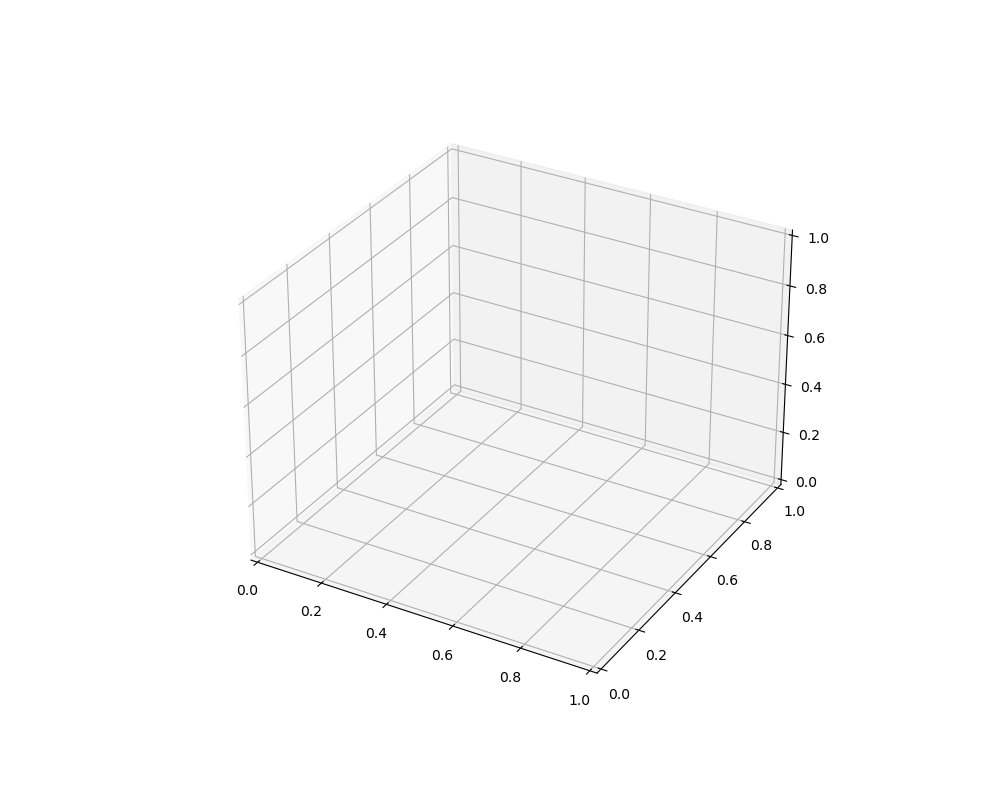

In [19]:
%matplotlib widget

# Plot the event
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

id_ = 0

event = hits[id_]

# print(df_hits.reco_hit_id.unique())

part_1 = event[event.reco_hit_id <0]
part_2 = event[event.reco_hit_id >0]

ax.scatter(0,0,0, marker='x',color="r")

ax.scatter(part_1['x'], part_1['y'], part_1['z'], marker='o',alpha=1)
ax.scatter(part_2['x'], part_2['y'], part_2['z'], marker='o',alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

# Plot the event
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

event = hits[id_]

part_ = df_particles_allevts[df_particles_allevts.event_id == hits[id_].iloc[0].event_id]
display(part_[part_.primary == 1])

# print(df_hits.reco_hit_id.unique())

part_1 = event[event.reco_hit_id <0]
part_2 = event[event.reco_hit_id >0]

# part_1 = event[event.particle_id == 1]
# part_2 = event[event.particle_id == 2]

ax.scatter(0,0,0, marker='x',color="r")

ax.scatter(part_1['x'], part_1['y'], part_1['z'], marker='o',alpha=1)
ax.scatter(part_2['x'], part_2['y'], part_2['z'], marker='o',alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_zlim(-20,20)
plt.show()

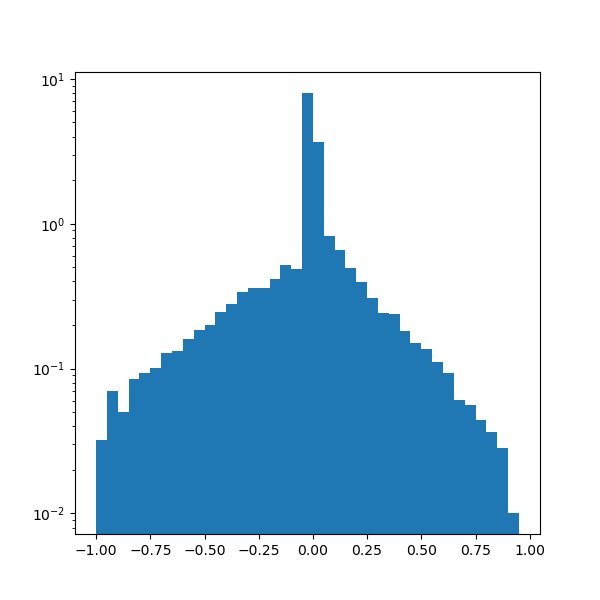

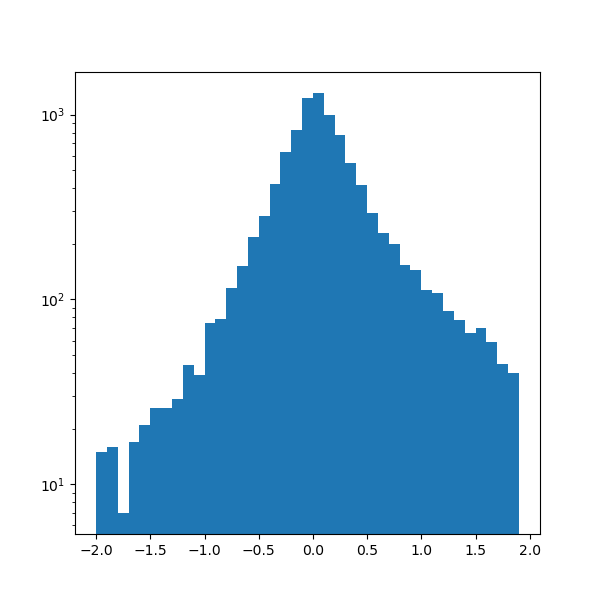

In [22]:
plt.figure(figsize=(6,6))

plt.hist(T1_reco_arr - T1_gen_arr, bins = np.arange(-1,1,0.05), density=True, log=True);
plt.figure(figsize=(6,6))
plt.hist(costheta_reco_arr - costheta_gen_arr, bins = np.arange(-2,2,0.1), log=True);

In [ ]:
# Fill a new pandas dataframe with the numpy arrays, then write to a csv file
mydict_reco = {'event_id':event_id_arr,
           'T1_gen':T1_gen_arr,
           'costheta_gen':costheta_gen_arr,
           'T1_true':T1_true_arr,
           'costheta_true':costheta_true_arr,
           'T1_reco':T1_reco_arr,
           'costheta_reco':costheta_reco_arr}

df_reco = pd.DataFrame(mydict_reco) 
file_out = f"../h5files/4mm/reco_{model}_{pressure}bar_{reco_seed_method}_{R}mm.csv"
df_reco.to_csv(file_out, sep=',', index=False) 

FileNotFoundError: [Errno 2] No such file or directory: '../h5files/4mm/reco_mbb_5bar_vertex_seed_12mm.csv'